# **Training Various Neural Network Architectures on Fashion MNIST Dataset** #

## **Initial Setup** ##

In [ ]:
!pip install torch
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## **External Libraries** ##

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset, Dataset
import pandas as pd
from torchvision import transforms
import numpy as np
import os
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

## **Loading the Fashion MNIST dataset.** ##

In [ ]:
!kaggle datasets download -d zalando-research/fashionmnist
!unzip fashionmnist.zip -d fashionmnist/

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
 97% 67.0M/68.8M [00:03<00:00, 23.2MB/s]
100% 68.8M/68.8M [00:04<00:00, 17.9MB/s]
Archive:  fashionmnist.zip
  inflating: fashionmnist/fashion-mnist_test.csv  
  inflating: fashionmnist/fashion-mnist_train.csv  
  inflating: fashionmnist/t10k-images-idx3-ubyte  
  inflating: fashionmnist/t10k-labels-idx1-ubyte  
  inflating: fashionmnist/train-images-idx3-ubyte  
  inflating: fashionmnist/train-labels-idx1-ubyte  


## **Feed Forward Neural Network** ##

### **Network Architecture.** ###

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(784, 620)  # Input layer
        self.fc2 = nn.Linear(620, 456)  # Hidden layer 1
        self.fc3 = nn.Linear(456, 292)  # Hidden layer 2
        self.fc4 = nn.Linear(292, 128)  # Hidden layer 3
        self.fc_output = nn.Linear(128, 10)  # Output layer

    def forward(self, x):
        # Flatten the input (Fashion MNIST images are 28x28 pixels)
        x = x.view(-1, 784)

        # Pass through the layers with ReLU activations
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc_output(x)  # No activation for the final output layer
        return x

# Instantiate the network and print its architecture
my_nn = Net()
print(my_nn)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_nn.parameters(), lr=0.001)

Net(
  (fc1): Linear(in_features=784, out_features=620, bias=True)
  (fc2): Linear(in_features=620, out_features=456, bias=True)
  (fc3): Linear(in_features=456, out_features=292, bias=True)
  (fc4): Linear(in_features=292, out_features=128, bias=True)
  (fc_output): Linear(in_features=128, out_features=10, bias=True)
)


### **Data Preprocessing** ###

In [ ]:
# Load CSV files
train_data = pd.read_csv('fashionmnist/fashion-mnist_train.csv')
val_data = pd.read_csv('fashionmnist/fashion-mnist_test.csv')

# Separate features and labels for training and test sets
X_train = train_data.iloc[:, 1:].values / 255.0  # Normalize pixel values to [0, 1]
y_train = train_data.iloc[:, 0].values           # Labels

X_val = val_data.iloc[:, 1:].values / 255.0    # Normalize pixel values to [0, 1]
y_val = val_data.iloc[:, 0].values             # Labels

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

### **Model Training (100 Epochs)** ###

In [ ]:
# Initialize lists to store losses and accuracy values for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Training phase
    my_nn.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()              # Clear gradients
        outputs = my_nn(images)            # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()                    # Backward pass
        optimizer.step()                   # Update weights

        running_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Average training loss and accuracy for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    my_nn.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():  # Disable gradient tracking for validation
        for images, labels in val_loader:
            outputs = my_nn(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Average validation loss and accuracy for the epoch
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_accuracy*100:.4f}%, Val Acc: {val_accuracy*100:.4f}%")

Epoch [1/100], Train Loss: 0.3326, Val Loss: 0.3206, Train Acc: 87.9483%, Val Acc: 88.1900%
Epoch [2/100], Train Loss: 0.3082, Val Loss: 0.3283, Train Acc: 88.6933%, Val Acc: 87.4900%
Epoch [3/100], Train Loss: 0.2904, Val Loss: 0.3444, Train Acc: 89.2633%, Val Acc: 88.0400%
Epoch [4/100], Train Loss: 0.2749, Val Loss: 0.3198, Train Acc: 89.8500%, Val Acc: 88.5900%
Epoch [5/100], Train Loss: 0.2633, Val Loss: 0.3373, Train Acc: 90.2667%, Val Acc: 88.0300%
Epoch [6/100], Train Loss: 0.2496, Val Loss: 0.3127, Train Acc: 90.6617%, Val Acc: 89.6500%
Epoch [7/100], Train Loss: 0.2412, Val Loss: 0.3024, Train Acc: 90.8900%, Val Acc: 89.3600%
Epoch [8/100], Train Loss: 0.2316, Val Loss: 0.3040, Train Acc: 91.3333%, Val Acc: 89.2600%
Epoch [9/100], Train Loss: 0.2202, Val Loss: 0.3058, Train Acc: 91.5950%, Val Acc: 89.3000%
Epoch [10/100], Train Loss: 0.2148, Val Loss: 0.2998, Train Acc: 91.8817%, Val Acc: 89.8500%
Epoch [11/100], Train Loss: 0.2039, Val Loss: 0.3207, Train Acc: 92.3450%, Val 

### **Results** ###

In [ ]:
# Final training and validation accuracy
print(f"Final Training Accuracy: {train_accuracies[-1]*100:.4f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]*100:.4f}%")

Final Training Accuracy: 98.7833%
Final Validation Accuracy: 90.4600%


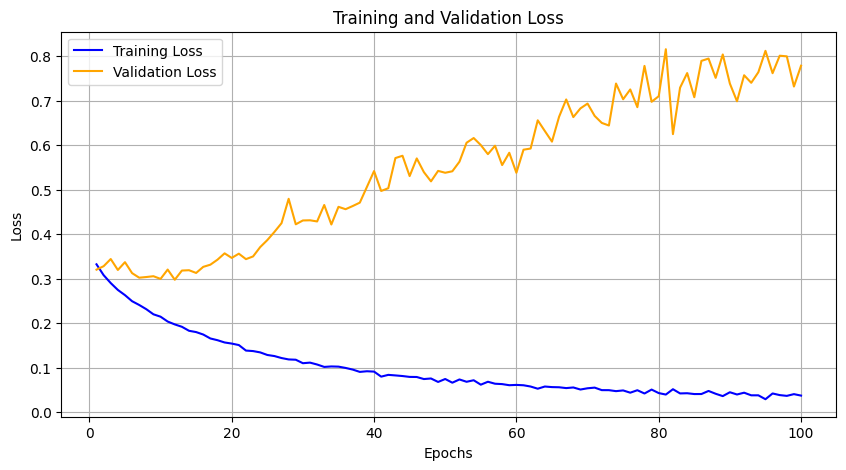

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

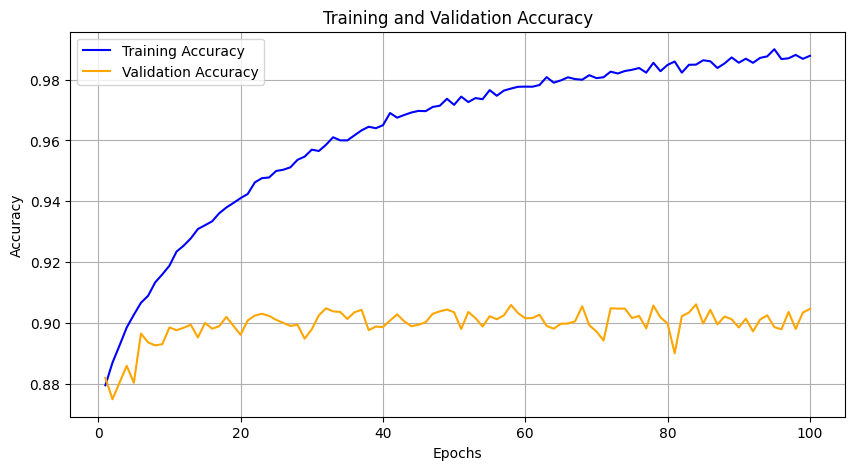

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## **Convolutional Neural Network** ##

### **Network Architecture** ###

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # 1 input channel (grayscale), 32 filters
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # 64 filters

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling to reduce spatial dimensions

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Input size matches flattened conv output
        self.fc2 = nn.Linear(128, 64)  # Hidden layer
        self.fc_output = nn.Linear(64, 10)  # Output layer (10 classes for Fashion MNIST)

    def forward(self, x):
        # Pass through convolutional layers with ReLU activation and pooling
        x = torch.relu(self.conv1(x))  # First conv layer
        x = self.pool(x)               # First pooling layer
        x = torch.relu(self.conv2(x))  # Second conv layer
        x = self.pool(x)               # Second pooling layer

        # Flatten the output from conv layers
        x = x.view(-1, 64 * 7 * 7)

        # Pass through fully connected layers with ReLU activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc_output(x)  # No activation for the final output layer (logits)

        return x

# Instantiate the network and print its architecture
my_nn_2 = Net()
print(my_nn_2)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(my_nn_2.parameters(), lr=0.001)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc_output): Linear(in_features=64, out_features=10, bias=True)
)


### **Data Preprocessing** ###

In [ ]:
# Load CSV files
train_data = pd.read_csv('fashionmnist/fashion-mnist_train.csv')
val_data = pd.read_csv('fashionmnist/fashion-mnist_test.csv')

# Separate features and labels for training and validation sets
X_train = train_data.iloc[:, 1:].values / 255.0  # Normalize pixel values to [0, 1]
y_train = train_data.iloc[:, 0].values           # Labels

X_val = val_data.iloc[:, 1:].values / 255.0    # Normalize pixel values to [0, 1]
y_val = val_data.iloc[:, 0].values             # Labels

# Reshape inputs to [batch_size, channels, height, width]
X_train = X_train.reshape(-1, 1, 28, 28)  # -1 infers the batch size
X_val = X_val.reshape(-1, 1, 28, 28)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

### **Model Training (10 Epochs)** ###

In [ ]:
# Initialize lists to store losses and accuracy values for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    my_nn_2.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()              # Clear gradients
        outputs = my_nn_2(images)            # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()                    # Backward pass
        optimizer.step()                   # Update weights

        running_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Average training loss and accuracy for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    my_nn_2.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():  # Disable gradient tracking for validation
        for images, labels in val_loader:
            outputs = my_nn_2(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Average validation loss and accuracy for the epoch
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_accuracy*100:.4f}%, Val Acc: {val_accuracy*100:.4f}%")

Epoch [1/10], Train Loss: 0.5298, Val Loss: 0.3641, Train Acc: 80.1700%, Val Acc: 86.4300%
Epoch [2/10], Train Loss: 0.3203, Val Loss: 0.2957, Train Acc: 88.4600%, Val Acc: 89.3200%
Epoch [3/10], Train Loss: 0.2719, Val Loss: 0.2573, Train Acc: 90.2700%, Val Acc: 90.3700%
Epoch [4/10], Train Loss: 0.2384, Val Loss: 0.2363, Train Acc: 91.1883%, Val Acc: 91.1400%
Epoch [5/10], Train Loss: 0.2131, Val Loss: 0.2432, Train Acc: 92.2133%, Val Acc: 90.8600%
Epoch [6/10], Train Loss: 0.1910, Val Loss: 0.2300, Train Acc: 92.9367%, Val Acc: 91.9300%
Epoch [7/10], Train Loss: 0.1715, Val Loss: 0.2174, Train Acc: 93.6417%, Val Acc: 92.1300%
Epoch [8/10], Train Loss: 0.1544, Val Loss: 0.2336, Train Acc: 94.3067%, Val Acc: 91.8900%
Epoch [9/10], Train Loss: 0.1367, Val Loss: 0.2234, Train Acc: 94.9500%, Val Acc: 92.0700%
Epoch [10/10], Train Loss: 0.1205, Val Loss: 0.2246, Train Acc: 95.5600%, Val Acc: 92.8800%


### **Results** ###

In [ ]:
# Final training and validation accuracy
print(f"Final Training Accuracy: {train_accuracies[-1]*100:.4f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]*100:.4f}%")

Final Training Accuracy: 95.5600%
Final Validation Accuracy: 92.8800%


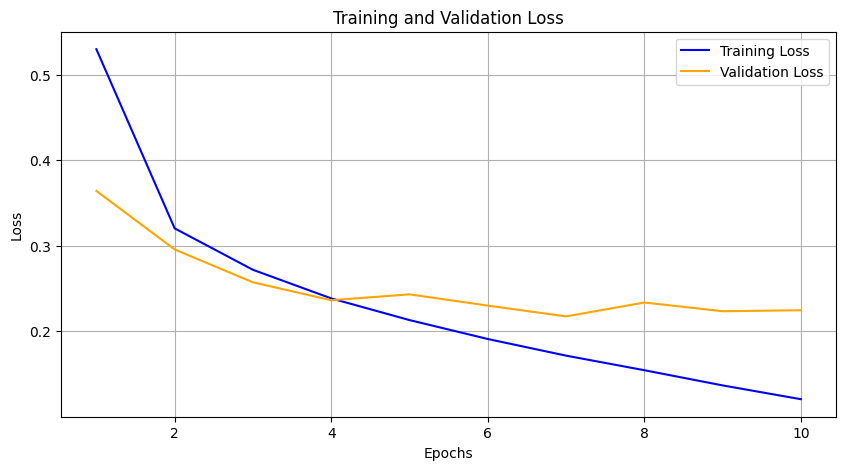

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

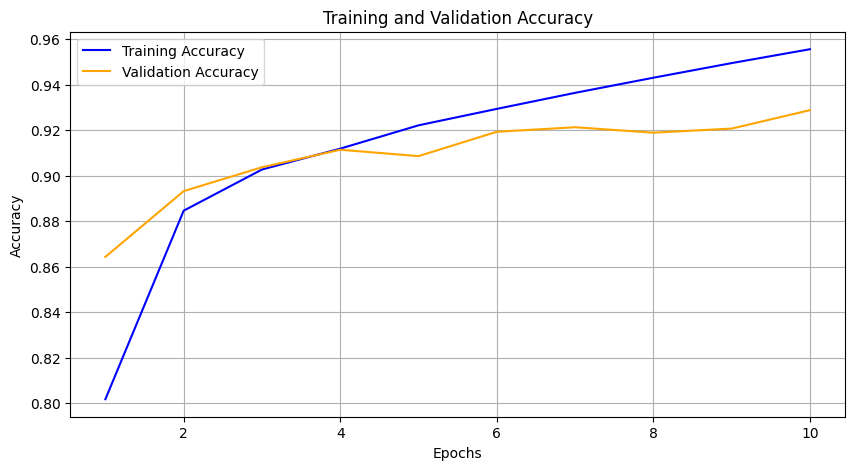

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

## **Transfer Learning - (Pre-trained VGG-16 network trained on ImageNet as a feature extractor, connected to a feed forward network)** ##

### **Network Architecture** ###

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Load pre-trained VGG-16 model
        self.vgg16 = models.vgg16(pretrained=True)

        # Freeze the parameters of the VGG-16 model
        for param in self.vgg16.parameters():
            param.requires_grad = False

        # Replace the classifier part of VGG-16
        self.vgg16.classifier = nn.Sequential(*list(self.vgg16.classifier.children())[:-1])  # Remove last layer

        # Fully connected layers
        self.fc1 = nn.Linear(4096, 620)  # Adjust input size to match VGG output
        self.fc2 = nn.Linear(620, 128)   # Hidden layer 1
        self.fc_output = nn.Linear(128, 10)   # Output layer for 10 classes

    def forward(self, x):
        # Use VGG-16 to extract features
        x = self.vgg16(x)  # VGG expects input in shape (N, C, H, W)

        # Pass through the fully connected layers with ReLU activations
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc_output(x)  # No activation for the final output layer
        return x

# Instantiate the network and print its architecture
my_nn_3 = Net()
print(my_nn_3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(my_nn_3.parameters(), lr=0.001)

# Use mixed precision
scaler = torch.cuda.amp.GradScaler()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Net(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxP

<ipython-input-9-27e930464481>:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


### **Data Preprocessing** ###

In [ ]:
# Load CSV files
train_data = pd.read_csv('fashionmnist/fashion-mnist_train.csv')
val_data = pd.read_csv('fashionmnist/fashion-mnist_test.csv')

# Separate features and labels for training and validation sets
X_train = train_data.iloc[:, 1:].values / 255.0  # Normalize pixel values to [0, 1]
y_train = train_data.iloc[:, 0].values           # Labels

X_val = val_data.iloc[:, 1:].values / 255.0    # Normalize pixel values to [0, 1]
y_val = val_data.iloc[:, 0].values             # Labels

# Custom Dataset class
class FashionMNISTDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = torch.tensor(self.data[idx].reshape(1, 28, 28), dtype=torch.float32)
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Define transformation for VGG input
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),       # Resize to VGG input size
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels
    transforms.ToTensor()                  # Convert to tensor
])

# Initialize datasets and data loaders
train_dataset = FashionMNISTDataset(X_train, y_train, transform=transform)
val_dataset = FashionMNISTDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Smaller batch size
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### **Model Training (20 Epochs)** ###

In [ ]:
# Initialize lists to store losses and accuracy values for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 20
accumulation_steps = 2  # Gradient accumulation steps
my_nn_3 = my_nn_3.to('cuda')  # Move model to GPU

for epoch in range(num_epochs):
    # Training phase
    my_nn_3.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    optimizer.zero_grad()  # Initialize optimizer gradients
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU

        with torch.cuda.amp.autocast():  # Mixed precision
            outputs = my_nn_3(images)  # Forward pass
            loss = criterion(outputs, labels) / accumulation_steps  # Normalize loss

        scaler.scale(loss).backward()  # Backward pass with scaling

        if (i + 1) % accumulation_steps == 0:  # Update weights every few batches
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()  # Clear gradients

        running_train_loss += loss.item() * accumulation_steps  # Adjust loss
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Average training loss and accuracy for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    my_nn_3.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():  # Disable gradient tracking for validation
        for images, labels in val_loader:
            images, labels = images.to('cuda'), labels.to('cuda')  # Move data to GPU
            outputs = my_nn_3(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Average validation loss and accuracy for the epoch
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_accuracy*100:.4f}%, Val Acc: {val_accuracy*100:.4f}%")

<ipython-input-11-5ade199b998a>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision


Epoch [1/20], Train Loss: 0.5713, Val Loss: 0.4389, Train Acc: 78.9417%, Val Acc: 83.3100%
Epoch [2/20], Train Loss: 0.4843, Val Loss: 0.3900, Train Acc: 82.0050%, Val Acc: 85.2600%
Epoch [3/20], Train Loss: 0.4569, Val Loss: 0.3597, Train Acc: 82.8300%, Val Acc: 86.3600%
Epoch [4/20], Train Loss: 0.4396, Val Loss: 0.3673, Train Acc: 83.5567%, Val Acc: 85.7900%
Epoch [5/20], Train Loss: 0.4279, Val Loss: 0.3592, Train Acc: 83.9733%, Val Acc: 86.4700%
Epoch [6/20], Train Loss: 0.4186, Val Loss: 0.3404, Train Acc: 84.2917%, Val Acc: 87.0300%
Epoch [7/20], Train Loss: 0.4077, Val Loss: 0.3397, Train Acc: 84.5783%, Val Acc: 87.1800%
Epoch [8/20], Train Loss: 0.3994, Val Loss: 0.3467, Train Acc: 84.8433%, Val Acc: 86.9700%
Epoch [9/20], Train Loss: 0.3948, Val Loss: 0.3328, Train Acc: 85.0467%, Val Acc: 87.5400%
Epoch [10/20], Train Loss: 0.3898, Val Loss: 0.3359, Train Acc: 85.2367%, Val Acc: 87.0900%
Epoch [11/20], Train Loss: 0.3836, Val Loss: 0.3248, Train Acc: 85.4983%, Val Acc: 87.680

### **Results** ###

In [ ]:
# Final training and validation accuracy
print(f"Final Training Accuracy: {train_accuracies[-1]*100:.4f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]*100:.4f}%")

Final Training Accuracy: 86.2433%
Final Validation Accuracy: 88.1100%


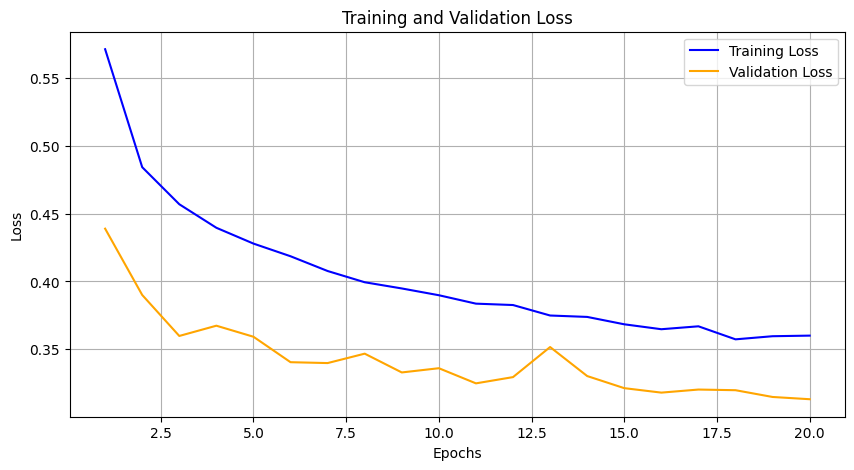

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

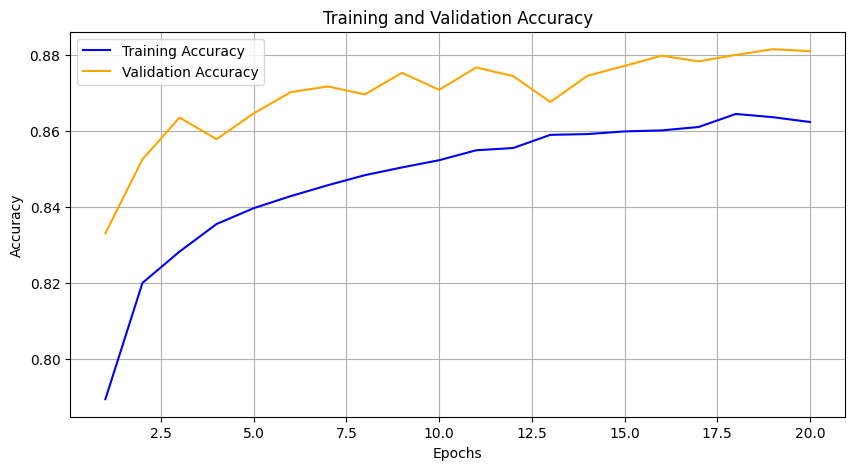

In [ ]:
# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()